In [ ]:
!pip install kaggle


In [10]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  
# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 69 bytes


In [11]:
!kaggle datasets download "jordidelatorreuoc/kaggle-plant-pathology-2021-modificat"

100% 969M/970M [00:15<00:00, 62.3MB/s]
100% 970M/970M [00:15<00:00, 66.9MB/s]


In [ ]:
!unzip kaggle-plant-pathology-2021-modificat.zip

In [29]:
import pandas as pd
import numpy as np 
import tensorflow as tf
import keras 
import os
import matplotlib.pylab as plt
import cv2
from keras.preprocessing.image import ImageDataGenerator 
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout, ZeroPadding2D, GlobalAveragePooling2D,BatchNormalization
from keras.optimizers import Adam, SGD,RMSprop,Adadelta,Adagrad,Adamax,Nadam,Ftrl
from keras.layers.experimental.preprocessing import Resizing


In [3]:
p = 'train'

images = []
classes = []

with os.scandir(p) as out:
    print('train:')
    for dirs in out:
        l = os.listdir(dirs)
        images.append(len(l))
        classes.append(dirs.name)
        print(dirs.name, ':', len(l))    
        
p = 'test'

with os.scandir(p) as out:
    print('test:')
    print(len([dir for dir in out]))

train:
C3 : 1100
C1 : 1000
C2 : 1200
C5 : 1150
C0 : 4000
C4 : 1300
test:
7527


C3
total images: 1100
% of total: 11.28 %
% of ill: 12.72 %
C1
total images: 1000
% of total: 10.26 %
% of ill: 11.559999999999999 %
C2
total images: 1200
% of total: 12.31 %
% of ill: 13.87 %
C5
total images: 1150
% of total: 11.790000000000001 %
% of ill: 13.29 %
C0
total images: 4000
% of total: 41.03 %
C4
total images: 1300
% of total: 13.33 %
% of ill: 15.03 %
total images of ill: 8650


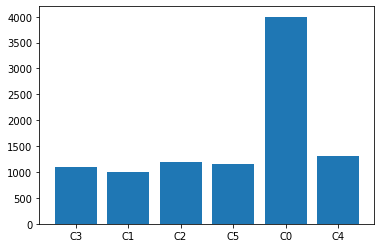

In [4]:
# class balances 
mysum = sum(images)
mysum_ill = sum(images[1:])

for c,n in list(zip(classes,images)):
    print(c)
    print('total images:', n)
    print('% of total:', round(n/mysum,4)*100,'%')
    if c!='C0':
        print('% of ill:', round(n/mysum_ill,4)*100,'%')
        
print('total images of ill:', mysum_ill)

plt.bar(classes,images);

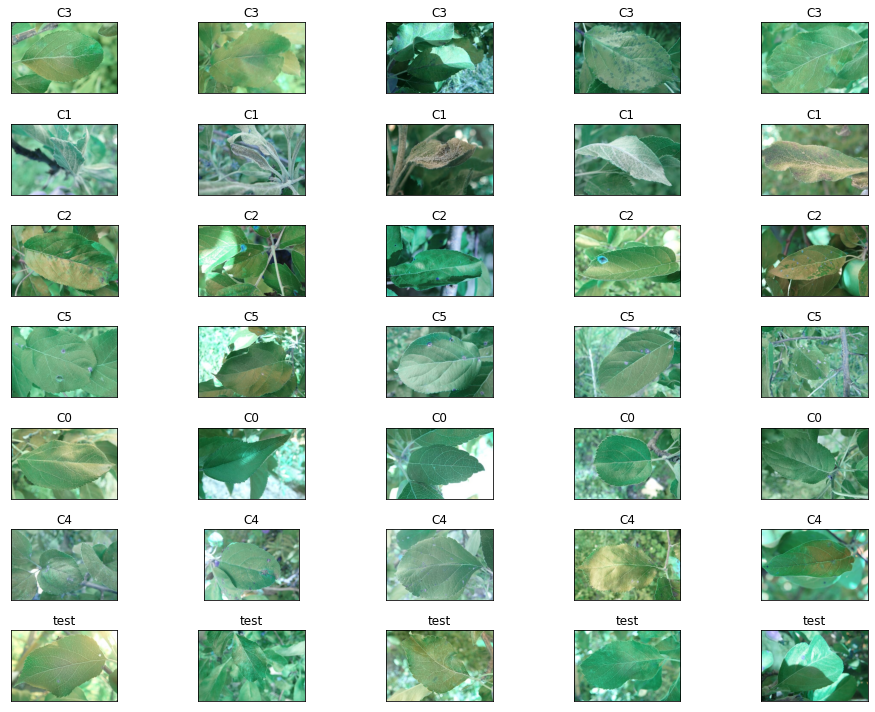

In [11]:
fig,i = plt.figure(figsize=(15, 10)),1

with os.scandir('train') as out:
    for dirs in out:
      l = os.listdir(dirs)
      for x in range(5):
        image = os.path.join(dirs, l[x])
        img = cv2.imread(image)
        ax = fig.add_subplot(7, 5, i)
        ax.set_title(dirs.name)
        plt.imshow(img)
        plt.xticks([]), plt.yticks([])
        plt.tight_layout()
        i += 1


with os.scandir('test') as out:
    for dir in [dir for dir in out]:
      image = os.path.join(dir)
      img = cv2.imread(image)
      ax = fig.add_subplot(7, 5, i)
      ax.set_title('test')
      plt.imshow(img)
      plt.xticks([]), plt.yticks([])
      plt.tight_layout()
      i += 1
      if i==36:
        break


In [13]:
# image shapes : height x width x channels
with os.scandir('train') as out:
    for dirs in out:
      l = os.listdir(dirs)
      image = os.path.join(dirs, l[66])
      img = cv2.imread(image)
      print(dirs.name)
      print("Image shape:",img.shape)
      print("Image range:",min(np.ravel(img)),max(np.ravel(img)))
            
                
with os.scandir('test') as out:
    for dir in [dir for dir in out]:
      image = os.path.join(dir)
      img = cv2.imread(image)
      print('test')
      print("Image shape:",img.shape)
      print("Image range:",min(np.ravel(img)),max(np.ravel(img)))
      break

C3
Image shape: (332, 498, 3)
Image range: 3 255
C1
Image shape: (332, 498, 3)
Image range: 6 255
C2
Image shape: (332, 498, 3)
Image range: 12 255
C5
Image shape: (332, 498, 3)
Image range: 0 255
C0
Image shape: (373, 498, 3)
Image range: 4 255
C4
Image shape: (373, 498, 3)
Image range: 16 255
test
Image shape: (332, 498, 3)
Image range: 42 255


TRAIN VAL 

In [14]:
datagen_train = ImageDataGenerator(
    validation_split=0.20) 

train_generator = datagen_train.flow_from_directory( 
    'train',
    subset='training')

validation_generator = datagen_train.flow_from_directory(
    'train',
    subset='validation'
    ,shuffle=False)

Found 7800 images belonging to 6 classes.
Found 1950 images belonging to 6 classes.


DATA AUGMENTATION

In [16]:
datagen_train = ImageDataGenerator(
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=[0.8,1.2],
    zoom_range=[0.5,1.2],
    rotation_range=20,
    rescale=1./255,
    validation_split=0.2) 

train_generator = datagen_train.flow_from_directory( 
    'train',
    subset='training')

validation_generator = datagen_train.flow_from_directory(
    'train',
    subset='validation'
    ,shuffle=False)



Found 7800 images belonging to 6 classes.
Found 1950 images belonging to 6 classes.


BASE CNN MODEL

In [20]:

base_model = Sequential()
base_model.add(keras.Input(shape=(332, 498, 3)))

base_model.add(Resizing(64,64))

base_model.add(Conv2D(32, 5, padding="same", strides=(1, 1), activation="relu"))
base_model.add(MaxPool2D(pool_size=(2, 2)))

base_model.add(Conv2D(64, 5, padding="same", strides=(1, 1), activation="relu"))
base_model.add(MaxPool2D(pool_size=(2, 2)))

base_model.add(Conv2D(128, 5, padding="same", strides=(1, 1), activation="relu"))
base_model.add(MaxPool2D(pool_size=(2, 2)))

# small filters = small features 

base_model.add(Flatten())

base_model.add(Dense(1024,activation="relu"))
base_model.add(Dropout(0.4))

base_model.add(Dense(6, activation="softmax"))

base_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
module_wrapper_2 (ModuleWrap (None, 64, 64, 3)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 32)        2432      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 64)        51264     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 16, 16, 128)       204928    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 128)        

In [23]:
from keras import backend as K

def custom_recall(y_true, y_pred):
  TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
  Positives = K.sum(K.round(K.clip(y_true, 0, 1)))
  recall = TP / (Positives+K.epsilon())
  return recall 

def custom_precision(y_true, y_pred):
  TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
  Pred_Positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
  precision = TP / (Pred_Positives+K.epsilon())
  return precision

def custom_f1(y_true, y_pred):    
    precision, recall = custom_precision(y_true, y_pred), custom_recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [ ]:
base_model.compile(optimizer = Adam(learning_rate=0.0001), 
              loss = "categorical_crossentropy", 
              metrics = ['accuracy',custom_f1,custom_recall,custom_precision])

early_stopping = keras.callbacks.EarlyStopping(monitor='val_custom_f1', mode='max', patience=5, restore_best_weights=True, verbose=2)

base_history = base_model.fit(train_generator,
                              validation_data = validation_generator,
                              epochs=100,
                              batch_size=32,
                              callbacks=[early_stopping],
                              verbose=1) 

Epoch 1/100
244/244 [==============================] - 252s 1s/step - loss: 1.2515 - accuracy: 0.5360 - custom_f1: 0.4498 - custom_recall: 0.3437 - custom_precision: 0.6850 - val_loss: 1.2718 - val_accuracy: 0.5354 - val_custom_f1: 0.4383 - val_custom_recall: 0.3658 - val_custom_precision: 0.5565
Epoch 2/100
244/244 [==============================] - 250s 1s/step - loss: 1.2355 - accuracy: 0.5544 - custom_f1: 0.4632 - custom_recall: 0.3538 - custom_precision: 0.6880 - val_loss: 1.2381 - val_accuracy: 0.5431 - val_custom_f1: 0.4799 - val_custom_recall: 0.4170 - val_custom_precision: 0.5736
Epoch 3/100
244/244 [==============================] - 250s 1s/step - loss: 1.2197 - accuracy: 0.5518 - custom_f1: 0.4793 - custom_recall: 0.3712 - custom_precision: 0.6994 - val_loss: 1.2013 - val_accuracy: 0.5713 - val_custom_f1: 0.4548 - val_custom_recall: 0.3596 - val_custom_precision: 0.6349
Epoch 4/100
244/244 [==============================] - 249s 1s/step - loss: 1.2210 - accuracy: 0.5606 - cu

ACURRACY AUGMENTATION TECHNIQUES

trying deeper arquitectures, AlexNet inspiration

In [32]:
deeper_model = Sequential()
deeper_model.add(keras.Input(shape=(332, 498, 3)))
deeper_model.add(Resizing(32,32))

deeper_model.add(Conv2D(filters=96, input_shape=(32,32,3), kernel_size=(11,11), strides=(4,4), padding='same', activation="relu"))
deeper_model.add(BatchNormalization())
deeper_model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same'))


deeper_model.add(Conv2D(filters=256, kernel_size=(5, 5), strides=(1,1), padding='same', activation="relu"))
deeper_model.add(BatchNormalization())
deeper_model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same'))


deeper_model.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='same', activation="relu"))
deeper_model.add(BatchNormalization())

deeper_model.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='same', activation="relu"))
deeper_model.add(BatchNormalization())


deeper_model.add(Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='same', activation="relu"))
deeper_model.add(BatchNormalization())
deeper_model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same'))


deeper_model.add(Flatten())
deeper_model.add(Dense(4096, input_shape=(32,32,3,), activation="relu"))
deeper_model.add(BatchNormalization())
deeper_model.add(Dropout(0.4))

deeper_model.add(Dense(4096, activation="relu"))
deeper_model.add(BatchNormalization())
deeper_model.add(Dropout(0.4))

deeper_model.add(Dense(1000, activation="relu"))
deeper_model.add(BatchNormalization())
deeper_model.add(Dropout(0.4))


deeper_model.add(Dense(6, activation="softmax"))
deeper_model.add(BatchNormalization())

deeper_model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
module_wrapper_7 (ModuleWrap (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 8, 8, 96)          34944     
_________________________________________________________________
batch_normalization_18 (Batc (None, 8, 8, 96)          384       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 4, 4, 96)          0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 4, 4, 256)         614656    
_________________________________________________________________
batch_normalization_19 (Batc (None, 4, 4, 256)         1024      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 2, 2, 256)        

In [33]:
deeper_model.compile(optimizer = Adam(learning_rate=0.0001), 
              loss = "categorical_crossentropy", 
              metrics = ['accuracy',custom_f1,custom_recall,custom_precision])

early_stopping = keras.callbacks.EarlyStopping(monitor='val_acc', patience=5, restore_best_weights=True, verbose=2)

deeper_history = deeper_model.fit(train_generator,
                              validation_data = validation_generator,
                              epochs=100,
                              batch_size=32,
                              callbacks=[early_stopping],
                              verbose=1) 

Epoch 1/100
244/244 [==============================] - 236s 943ms/step - loss: 7.8976 - accuracy: 0.1657 - custom_f1: 0.1816 - custom_recall: 0.2077 - custom_precision: 0.1617 - val_loss: 13.0979 - val_accuracy: 0.1138 - val_custom_f1: 0.1152 - val_custom_recall: 0.1163 - val_custom_precision: 0.1141
Epoch 2/100
244/244 [==============================] - 227s 928ms/step - loss: 7.0014 - accuracy: 0.1989 - custom_f1: 0.2129 - custom_recall: 0.2370 - custom_precision: 0.1937 - val_loss: 10.7811 - val_accuracy: 0.1574 - val_custom_f1: 0.1684 - val_custom_recall: 0.1872 - val_custom_precision: 0.1532
Epoch 3/100
244/244 [==============================] - 226s 924ms/step - loss: 8.1847 - accuracy: 0.2393 - custom_f1: 0.2444 - custom_recall: 0.2696 - custom_precision: 0.2239 - val_loss: 5.5526 - val_accuracy: 0.2467 - val_custom_f1: 0.2496 - val_custom_recall: 0.2586 - val_custom_precision: 0.2414
Epoch 4/100
244/244 [==============================] - 225s 922ms/step - loss: 7.4655 - accurac

TRANSFER LEARNING + FINE TUNING

In [ ]:
from keras.applications import Xception, InceptionV3, InceptionResNetV2, ResNet152
from tensorflow.keras.models import Model

XCEPTION

In [ ]:
############
# XCEPTION #
############
​
xception = Xception(weights='imagenet', include_top=False)
xception.trainable = False 
xception.summary()

In [ ]:
from keras.applications.xception import preprocess_input
​
resize = Resizing(299,299)(inputs)
​
preprocess = preprocess_input(resize)
​
my_xception = xception(preprocess, training=False)
​
my_xception = GlobalAveragePooling2D()(my_xception)
my_xception = Dense(1000)(my_xception)
my_xception = Dropout(0.5)(my_xception)
my_xception = Dense(6, activation="softmax")(my_xception)
​
my_xception_model = Model(inputs=inputs, outputs=my_xception)
​
my_xception_model.summary()

In [ ]:
my_xception_model.compile(optimizer=Adam(lr=0.0001),loss='categorical_crossentropy',
                          metrics=['accuracy',custom_f1,custom_recall,custom_precision])

early_stopping = keras.callbacks.EarlyStopping(monitor='val_acc', patience=5, restore_best_weights=True, verbose=2)

xception_history = my_xception_model.fit(train_generator,
                                         validation_data = validation_generator,
                                         epochs=25,
                                         verbose=1,
                                         batch_size=32,
                                         callbacks=[early_stopping]) ​

In [ ]:
# fine tuning 
​
xception.trainable = True
​
my_xception_model.compile(optimizer=Adam(1e-5),  # Very low learning rate
              loss='categorical_crossentropy',
              metrics=['accuracy',custom_f1,custom_recall,custom_precision])
​
early_stopping = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True, verbose=2)
​
xception_history = my_xception_model.fit(train_generator,
                                         validation_data = validation_generator,
                                         epochs=50,
                                         verbose=1,
                                         batch_size=32,
                                         callbacks=[early_stopping]) 

INCEPTION

In [ ]:
############
# InceptionV3 #
############

inception = InceptionV3(weights='imagenet', include_top=False)
inception.trainable = False 
inception.summary()

In [ ]:
from keras.applications.inception_v3 import preprocess_input
​
resize = Resizing(299,299)(inputs)

preprocess = preprocess_input(resize)

my_inception = inception(preprocess, training=False)

my_inception = GlobalAveragePooling2D()(my_inception)
my_inception = Dense(1000)(my_inception)
my_inception = Dropout(0.5)(my_inception)
my_inception = Dense(6, activation="softmax")(my_inception)

my_inception_model = Model(inputs=inputs, outputs=my_inception)

my_inception_model.summary()


In [ ]:
my_inception_model.compile(optimizer=Adam(lr=0.0001),loss='categorical_crossentropy',
                          metrics=['accuracy',custom_f1,custom_recall,custom_precision])

early_stopping = keras.callbacks.EarlyStopping(monitor='val_acc', patience=5, restore_best_weights=True, verbose=2)

inception_history = my_inception_model.fit(train_generator,
                                         validation_data = validation_generator,
                                         epochs=25,
                                         verbose=1,
                                         batch_size=32,
                                         callbacks=[early_stopping]) ​

In [ ]:
# fine tuning 
​
inception.trainable = True
​
my_inception_model.compile(optimizer=Adam(1e-5),  # Very low learning rate
              loss='categorical_crossentropy',
              metrics=['accuracy',custom_f1,custom_recall,custom_precision])
​
early_stopping = keras.callbacks.EarlyStopping(monitor='val_acc', patience=10, restore_best_weights=True, verbose=2)
​
inception_history = my_inception_model.fit(train_generator,
                                         validation_data = validation_generator,
                                         epochs=50,
                                         verbose=1,
                                         batch_size=32,
                                         callbacks=[early_stopping]) 

InceptionResNetV2

In [ ]:
############
# InceptionResNetV2 #
#############

inceptionResNet = InceptionResNetV2(weights='imagenet', include_top=False)
inceptionResNet.trainable = False 
inceptionResNet.summary()

In [ ]:
from keras.applications.inception_resnet_v2 import preprocess_input
​
resize = Resizing(299,299)(inputs)

preprocess = preprocess_input(resize)

my_inceptionResNet = inceptionResNet(preprocess, training=False)

my_inceptionResNet = GlobalAveragePooling2D()(my_inceptionResNet)
my_inceptionResNet = Dense(1000)(my_inceptionResNet)
my_inceptionResNet = Dropout(0.5)(my_inceptionResNet)
my_inceptionResNet = Dense(6, activation="softmax")(my_inceptionResNet)

my_inceptionResNet_model = Model(inputs=inputs, outputs=my_inceptionResNet)

my_inceptionResNet_model.summary()


In [ ]:
my_inceptionResNet_model.compile(optimizer=Adam(lr=0.0001),loss='categorical_crossentropy',
                          metrics=['accuracy',custom_f1,custom_recall,custom_precision])

early_stopping = keras.callbacks.EarlyStopping(monitor='val_acc', patience=5, restore_best_weights=True, verbose=2)

inceptionResNet_history = my_inceptionResNet_model.fit(train_generator,
                                         validation_data = validation_generator,
                                         epochs=25,
                                         verbose=1,
                                         batch_size=32,
                                         callbacks=[early_stopping]) ​

In [ ]:
# fine tuning 
​
inceptionResNet.trainable = True
​
my_inceptionResNet_model.compile(optimizer=Adam(1e-5),  # Very low learning rate
              loss='categorical_crossentropy',
              metrics=['accuracy',custom_f1,custom_recall,custom_precision])
​
early_stopping = keras.callbacks.EarlyStopping(monitor='val_acc', patience=10, restore_best_weights=True, verbose=2)
​
inceptionResNet_history = my_inceptionResNet_model.fit(train_generator,
                                         validation_data = validation_generator,
                                         epochs=50,
                                         verbose=1,
                                         batch_size=32,
                                         callbacks=[early_stopping]) 